## Decitabine treatment RNA-Seq time-series experiments
In order to test for any differences over multiple time points, once can use a design including the time factor, and then test using the **likelihood ratio test (LRT)**. Here, as we have control (DMSO) and treatment (Decitabine) time series, design formula containing the condition factor, the time factor, and the interaction of the two. In this case, using the likelihood ratio test with a reduced model which does not contain the interaction terms will test whether the condition induces a change in gene expression at any time point after the reference level time point (time 0). 

(see [DESeq2 Time-series-experiments](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#time-series-experiments) for more details)


## Pre-processing 

I'm mapping `hg38/gencode.v28` to the `fastq` files using salmon. 

Raw samples:

In [184]:
ls fastq/

120h_DMSO_rep1.fastq.gz*     6h_treated_rep1.fastq.gz*
120h_DMSO_rep2.fastq.gz*     6h_treated_rep2.fastq.gz*
120h_treated_rep1.fastq.gz*  72h_DMSO_rep1.fastq.gz*
120h_treated_rep2.fastq.gz*  72h_DMSO_rep2.fastq.gz*
6h_DMSO_rep1.fastq.gz*       72h_treated_rep1.fastq.gz*
6h_DMSO_rep2.fastq.gz*       72h_treated_rep2.fastq.gz*


Alignment script:

In [183]:
cat salmon.sh

for f in fastq/*; do 
	samp=`basename ${f}`; 
	samp=${samp/.fastq.gz/}; 
	echo "Processing sample ${samp}"; 
	salmon quant -i ~/genomes/hg38/gencode.v28/gencode.v28.transcripts.salmon_index/ \
	-l A -r $f -p 8 --validateMappings -o quants/$samp; 
done


In [2]:
%reload_ext rpy2.ipython

In [26]:
%%R 
library (GenomicFeatures)
library (tximport)
library (tidyverse)
library (ggplot2)
library (ggrepel)
library (DESeq2)
library (patchwork)
library (BiocParallel)
register(MulticoreParam(4))

plot_Save <- function (p, name_it){
    ggsave(paste(name_it,'png',sep='.'), plot = p, device = 'png', dpi = 300)
    ggsave(paste(name_it,'pdf',sep='.'), plot = p, device = 'pdf', dpi = 300)
}

Load annotations

In [27]:
%%R
GTF = '/rumi/shams/abe/genomes/hg38/gencode.v28.annotation.gtf'
gtf <- rtracklayer::import(GTF)
gene2name <- gtf[gtf$type == "gene"] %>% data.frame %>% column_to_rownames('gene_id') %>% dplyr::select('gene_name')

txdb  = makeTxDbFromGFF(GTF,organism='Homo sapiens')
# tx2gene objects 
k <- keys(txdb, keytype = "TXNAME")
tx2gene <- AnnotationDbi::select(txdb, k, "GENEID", "TXNAME")

R[write to console]: Import genomic features from the file as a GRanges object ... 
R[write to console]: OK

R[write to console]: Prepare the 'metadata' data frame ... 
R[write to console]: OK

R[write to console]: Make the TxDb object ... 
R[write to console]: OK

R[write to console]: 'select()' returned 1:1 mapping between keys and columns



import salmon quants:

In [28]:
%%R
files <- list.files(path='./quants', pattern="quant.sf",full.names = TRUE, recursive=T)
names(files) <- gsub("./quants/(\\S+)/quant.sf","\\1",files)

txi <- tximport(files, type = "salmon", tx2gene = tx2gene, txOut=T)

txi.gene <- summarizeToGene(txi, tx2gene, ignoreAfterBar= TRUE)

R[write to console]: reading in files with read_tsv

R[write to console]: 1 
R[write to console]: 2 
R[write to console]: 3 
R[write to console]: 4 
R[write to console]: 5 
R[write to console]: 6 
R[write to console]: 7 
R[write to console]: 8 
R[write to console]: 9 
R[write to console]: 10 
R[write to console]: 11 
R[write to console]: 12 
R[write to console]: 

R[write to console]: summarizing abundance

R[write to console]: summarizing counts

R[write to console]: summarizing length



Define the sample sheet

In [29]:
%%R 
# meta 
treats  <- rep(c(rep('DMSO',2), rep('treated',2)),3)
reps    <- rep(c('rep1','rep2'),6)
hours   <- c(rep('120h',4),rep('6h',4),rep('72h',4))
colData <- data.frame(
    time=hours, 
    cond=treats, 
    sample_id=paste(hours, treats, reps, sep='_'),
    row.names=colnames(txi$abundance))
colData

                  time    cond         sample_id
120h_DMSO_rep1    120h    DMSO    120h_DMSO_rep1
120h_DMSO_rep2    120h    DMSO    120h_DMSO_rep2
120h_treated_rep1 120h treated 120h_treated_rep1
120h_treated_rep2 120h treated 120h_treated_rep2
6h_DMSO_rep1        6h    DMSO      6h_DMSO_rep1
6h_DMSO_rep2        6h    DMSO      6h_DMSO_rep2
6h_treated_rep1     6h treated   6h_treated_rep1
6h_treated_rep2     6h treated   6h_treated_rep2
72h_DMSO_rep1      72h    DMSO     72h_DMSO_rep1
72h_DMSO_rep2      72h    DMSO     72h_DMSO_rep2
72h_treated_rep1   72h treated  72h_treated_rep1
72h_treated_rep2   72h treated  72h_treated_rep2


## PCA
Initial principal component analysis (PCA) shows the second treated biological replicate at 72h time point, behaves as an outlier. Removing that from the analysis give us a better representation of our dataset. In the second PCA plot, we can see that treated samples at 6h cluster with the non-treated samples which suggest that 6 hours treatment with the drug is not as effective as 72h and 120h. Although, we will check the variant genes in this time-point in the following statistical analysis.


In [30]:
%%R
plot_PCA <- function(vsd, colData=colData, gr=c('time', 'cond'), title=''){
    z <- plotPCA(vsd,intgroup=gr, returnData=TRUE)
    percentVar <- round(100 * attr(z, "percentVar"))
    pca <- ggplot(z, aes(PC1, PC2)) +
            geom_point(aes(size = 2,  shape=group), alpha = 4/10) +
            geom_text_repel(aes(label = row.names(colData)),size = 3.5) +
            xlab(paste0("PC1: ",percentVar[1],"% variance")) +
            ylab(paste0("PC2: ",percentVar[2],"% variance")) +
            guides (size = FALSE) +
            ggtitle (title)+ 
            theme(legend.position="none")
    return (pca)
}

In [31]:
%%R 
dds0 <- DESeqDataSetFromTximport(txi, colData, ~cond + time )
nrow(dds0)

R[write to console]: using counts and average transcript lengths from tximport



[1] 203027


R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates: 4 workers

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates, fitting model and testing: 4 workers



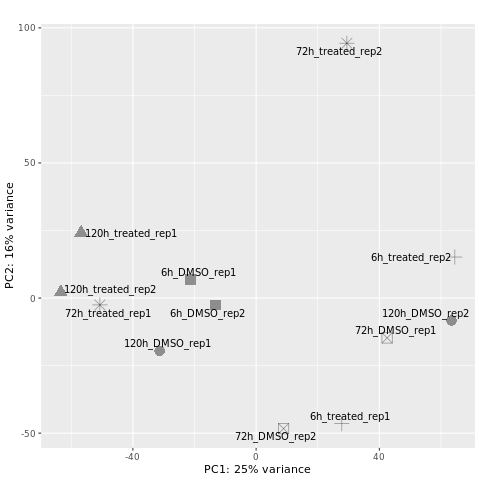

In [32]:
%%R 
dds.pca <- DESeq(dds0, parallel=TRUE)
# results 
vsd <- varianceStabilizingTransformation(dds.pca)

pca = plot_PCA(vsd, colData)
pca

In [33]:
%%R
plot_Save(pca,'PCA_raw')

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



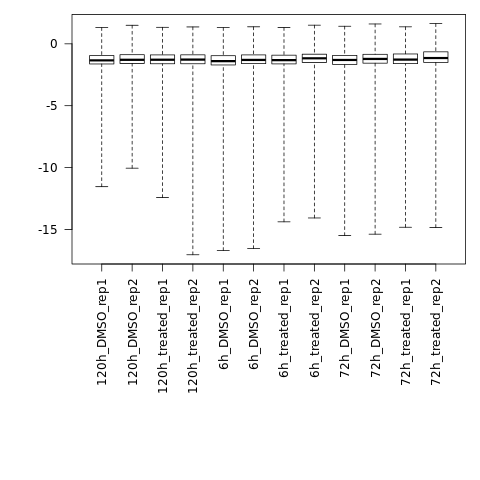

In [34]:
%%R
par(mar=c(15,5,1,1))
boxplot(log10(assays(dds.pca)[["cooks"]]), range=0, las=2)

Filter non-informative genes and outlier sample:

In [35]:
%%R 
# all samples with a count of higher than 10
keep <- rowSums(counts(dds0) > 10) == ncol(dds0)
# at least 3 samples with a count of 10 or higher
# keep <- rowSums(counts(dds) >= 10) >= 3

dds1 <- dds0[keep,-12]
dds1 <- DESeq(dds1, parallel=TRUE)
nrow(dds1)

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates: 4 workers

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates, fitting model and testing: 4 workers



[1] 24599


In [36]:
%%R
# results 
vsd <- varianceStabilizingTransformation(dds1)
p = plot_PCA(vsd, colData[-12,], title='Remove sample `72h_treated_rep2`')

Create seprate PCAs

In [37]:
%%R 
dds1 <- DESeqDataSetFromTximport(txi, colData, ~time)

U = grep('DMSO',    colnames(dds0), value=1)
T = grep('treated', colnames(dds0), value=1)[-6]

# subset
dds.U = dds1[keep, U]
# make object for the PCA
dds.pcaU <- DESeq(dds.U, parallel=TRUE)
vsd.U <- varianceStabilizingTransformation(dds.pcaU)
# plot it 
p.U = plot_PCA(vsd.U, colData[U,], gr=c('time'), title='Non-treated')


# subset
dds.T = dds1[keep, T]
# make object for the PCA
dds.pcaT <- DESeq(dds.T, parallel=TRUE)
vsd.T <- varianceStabilizingTransformation(dds.pcaT)
# plot it 
p.T = plot_PCA(vsd.T, colData[T,], gr=c('time'), title='Treated')

R[write to console]: using counts and average transcript lengths from tximport

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates: 4 workers

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates, fitting model and testing: 4 workers

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates: 4 workers

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates, fitting model and testing: 4 workers



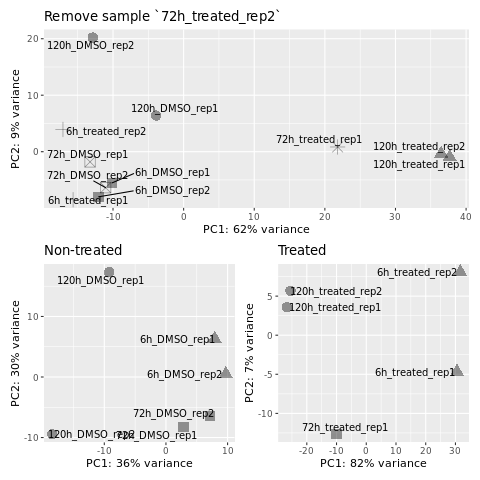

In [38]:
%%R
p / (p.U + p.T) 

In [39]:
%%R
plot_Save(p / (p.U + p.T), 'PCA_filtered')

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



# Differential expression analysis
I'm doing differential expression analysis at 6h,72h and 120h plus time-independent comparison. Volcano-plot for all four tests included. Notably, I'm replacing results for time dependent tests with missing values or less than 0.05 adjust p-values with results from time independent test. 

In addition, I use time as continues variable to run seprate analysis. 

In [40]:
%%R
plot_Volcano <- function(res, lfc.cutoff  = 1,pval.cutoff = 0.05, title='', x_min=-20,x_max=20){
    res$sig <- as.factor(res$pvalue < pval.cutoff & abs(res$log2FoldChange) > lfc.cutoff)
    relevel(res$sig, ref=TRUE)
    vol = res %>% ggplot(
        aes(x=log2FoldChange, y=-log10(pvalue), colour=sig, fill=sig)) +
        geom_point(aes(color = sig),alpha = 1/10) +
            xlim(c(x_min,x_max)) +
    #         ylim(c(0,11)) +
            geom_hline(yintercept=-log10(pval.cutoff), linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=lfc.cutoff, linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=(-1)*lfc.cutoff, linetype="dashed", alpha = 4/10) +
            scale_color_manual(values = c("grey", "red")) +
            theme_bw() + 
            theme(legend.position="none") +
            ggtitle (title) + 
            geom_text_repel(
                data = subset(res[order(res$pvalue),], sig == TRUE)[1:7,],
                aes(label = name),
                size = 3,
                box.padding = unit(0.35, "lines"),
                point.padding = unit(0.3, "lines")
            )
     return (vol)
} 

get_Result <- function(dds, design){
    res = results(dds, contrast=design, parallel=TRUE)  %>%
        data.frame %>% 
        add_column(name=gene2name[rownames(dds),]) %>%
        add_column(ensembl=rownames(dds) %>% substr(0, 15))
                
    res$log2FoldChange[is.na(res$log2FoldChange)] <- 0
    res$padj[is.na(res$padj)] <- 1
    return (res)
}

write_Result <- function(res, name_it, col=FALSE, row=FALSE){
    write.table(res,name_it, sep="\t", quote=FALSE, col.names=col, row.names=row)
}

### First scenario
Time as factor variable

In [41]:
%%R 
dds <- DESeqDataSetFromTximport(txi.gene, colData, ~cond + time + cond:time)

dds$time <- relevel(dds$time, ref="6h")

# Annova
dds <- DESeq(dds, test="LRT", reduced=~1, parallel=TRUE)
ncu <- counts(dds, normalized=TRUE) 
write.table(ncu,'DE2norm.txt', sep="\t", quote=FALSE, col.names=colData$sample_id)

R[write to console]: using counts and average transcript lengths from tximport

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates: 4 workers

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates, fitting model and testing: 4 workers



In [42]:
%%R
resultsNames(dds)

[1] "Intercept"            "cond_treated_vs_DMSO" "time_120h_vs_6h"     
[4] "time_72h_vs_6h"       "condtreated.time120h" "condtreated.time72h" 


In [43]:
%%R
dds_ind <- DESeqDataSetFromTximport(txi.gene, colData, ~cond + time)

dds_ind$time <- relevel(dds_ind$time, ref="6h")

dds_ind <- DESeq(dds_ind, test="LRT", reduced=~1, parallel=TRUE)

R[write to console]: using counts and average transcript lengths from tximport

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates: 4 workers

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates, fitting model and testing: 4 workers



In [44]:
%%R
resultsNames(dds_ind)

[1] "Intercept"            "cond_treated_vs_DMSO" "time_120h_vs_6h"     
[4] "time_72h_vs_6h"      


In [45]:
%%R
# no interaction
res.ind = get_Result(dds_ind,list('cond_treated_vs_DMSO'))
vol.ind  = plot_Volcano(res.ind, title='Treated vs DMSO')

# contrast design: treatment at 6h vs dmso at 6h
res.6h  = get_Result(dds, list('cond_treated_vs_DMSO'))
res.6h  [res.6h$padj   > 0.05,] = res.ind[res.6h$padj  > 0.05,]
vol.6h  = plot_Volcano(res.6h, title='Treated time: 6 hours')
# contrast design: treatment at 72h vs dmso at 72h
res.72h = get_Result(dds, list('cond_treated_vs_DMSO', 'condtreated.time72h'))
res.72h [res.72h$padj  > 0.05,] = res.ind[res.72h$padj > 0.05,]
vol.72h = plot_Volcano(res.72h, title='Treated time: 72 hours')

# contrast design: treatment at 120h vs dmso at 120h
res.120h= get_Result(dds, list('cond_treated_vs_DMSO', 'condtreated.time120h'))
res.120h[res.120h$padj > 0.05,] = res.ind[res.120h$padj> 0.05,]
vol.120h= plot_Volcano(res.120h, title='Treated time: 120 hours')

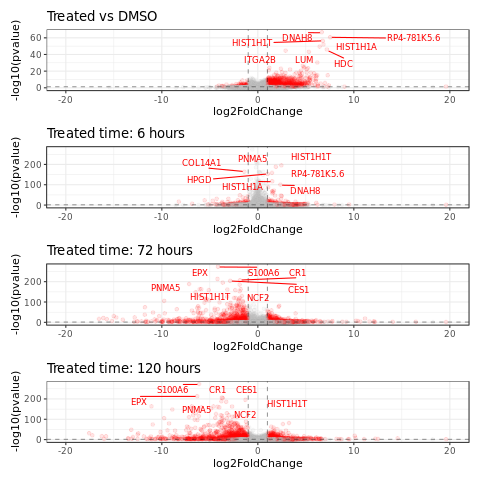

In [46]:
%%R
vol = vol.ind / vol.6h / vol.72h / vol.120h
vol

In [47]:
%%R
plot_Save(vol, 'Volcano_time_factor')

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



In [52]:
%%R    
df = data.frame(
    'gene_id'=rownames(res.ind), 'gene_name'= res.ind$name,
    'baseMean' = res.ind$baseMean,
    'log2FC_T_vs_U' = res.ind$log2FoldChange, 'pval_T_vs_U'= res.ind$pval,
    'log2FC_6h' = res.6h$log2FoldChange,'pval_6h'= res.6h$pval,
    'log2FC_72h' = res.72h$log2FoldChange,'pval_72h'= res.72h$pval,
    'log2FC_120h'  = res.120h$log2FoldChange,'pval_120h'= res.120h$pval)
    
df = df[order(df$log2FC_T_vs_U),]
    
write_Result(df, 'results_time_factor.txt', col=TRUE)

Prepare results for running iPAGE:

In [126]:
%%R 
write_Result(res.6h  [,c('ensembl','log2FoldChange')] %>% remove_rownames, '6h_DE2res.txt')
write_Result(res.72h [,c('ensembl','log2FoldChange')] %>% remove_rownames, '72h_DE2res.txt')
write_Result(res.120h[,c('ensembl','log2FoldChange')] %>% remove_rownames, '120h_DE2res.txt')

In [ ]:
%%bash
declare -a Comp=('6h' '72h' '120h')

for C in "${Comp[@]}"; do
	mkdir -p ${C}_PAGE
	for f in `ls -d /flash/bin/iPAGEv1.0/PAGE_DATA/ANNOTATIONS/human_ensembl*`; do
		base=`basename "$f"`
        perl $PAGEDIR/page.pl --expfile=${C}_DE2res.txt \
		--species=$base --exptype=continuous --ebins=11 --nodups=1
		mv -v ${C}_DE2res.txt_PAGE/ ${C}_PAGE/${base}/
	done
    rm ${C}_DE2res.txt
done

copy iPAGE heatmaps

In [67]:
%%bash
declare -a Comp=('6h' '72h' '120h')

for C in "${Comp[@]}"; do
    for f in ${C}_PAGE/human_ensembl*/*pdf; do 
        d=`dirname $f`; b=`basename $d`; 
        o=~/GitHub/Abe/People/Gilbertlab/Decitabine_treatment/time_RNA-seq/plots/${C}_PAGE_${b}.pdf; 
        cp -v $f $o
        bash ~/Workflows/my_scripts/pdf2png.sh $o       
    done 
done 

print out HTML 

In [64]:
%%bash
declare -a Comp=('6h' '72h' '120h')

for f in `ls -d /flash/bin/iPAGEv1.0/PAGE_DATA/ANNOTATIONS/human_ensembl*`; do
    base=`basename "$f"`
    echo '<table>'
    echo '  <tr>'
    echo '  <h2>'$base'<h2>'
    for C in "${Comp[@]}"; do
        echo '    <td><img src=plots/'${C}'_PAGE_'${base}'.png style="width:600px">'
    done
    echo '  <tr>'
    echo '<table>'
done

### Second scenario
Time as continues variable

In [53]:
%%R 
# meta 
colData.T <- data.frame(
    time=c(rep(120,4),rep(6,4),rep(72,4)), 
    cond=rep(c(rep('DMSO',2), rep('treated',2)),3), 
    time_cond=paste(hours,treats,sep='_'), 
    sample_id=colnames(txi$abundance),
    row.names=colnames(txi$abundance))

dds.T <- DESeqDataSetFromTximport(txi.gene, colData.T, ~cond + time + cond:time)
dds.T <- DESeq(dds.T, test="LRT", reduced=~1, parallel=TRUE)

R[write to console]: the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]: using counts and average transcript lengths from tximport

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates: 4 workers

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates, fitting model and testing: 4 workers



In [54]:
%%R
resultsNames(dds.T)

[1] "Intercept"            "cond_treated_vs_DMSO" "time"                
[4] "condtreated.time"    


In [55]:
%%R
res_cnt_time_T_vs_U = results(dds.T, name='cond_treated_vs_DMSO', parallel=T) %>% 
    data.frame %>% add_column(name = gene2name[rownames(dds.T),]) %>%
    add_column(ensembl = rownames(dds.T) %>% substr(0, 15))

p1 = plot_Volcano(res_cnt_time_T_vs_U, 0.1, title='Time as continuous variable: Treated vs DMSO', 
                  x_min=-2,x_max=2)

In [56]:
%%R
res_cnt_time = results(dds.T, name='condtreated.time', parallel=T) %>% 
    data.frame %>% add_column(name = gene2name[rownames(dds.T),]) %>%
    add_column(ensembl = rownames(dds.T) %>% substr(0, 15))

p2 = plot_Volcano(res_cnt_time, 0.01, title='Time as continuous variable: Condition and time interaction', 
                  x_min=-0.1,x_max=0.1)

In [57]:
%%R
df = data.frame(
    'gene_id'=rownames(res_cnt_time_T_vs_U), 'gene_name'= res_cnt_time_T_vs_U$name,
    'baseMean' = res_cnt_time$baseMean,
    'log2FC_time' = res_cnt_time$log2FoldChange,'log2FC_time'= res_cnt_time$pval,
    'log2FC_T_vs_U' = res_cnt_time_T_vs_U$log2FoldChange,'pval_T_vs_U'= res_cnt_time_T_vs_U$pval
)    
df = df[order(df$log2FC_time),]

write_Result(df, 'results_time_continuous.txt', col=TRUE)

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



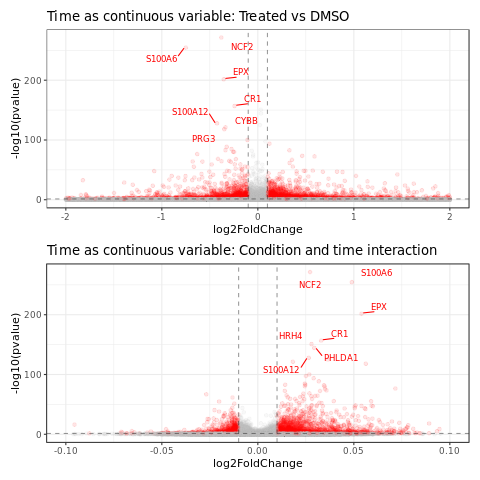

In [58]:
%%R
plot_Save(p1 / p2, 'Volcano_time_continuous')
p1 / p2

In [46]:
%%R
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/deseq/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] patchwork_1.0.0             DESeq2_1.20.0              
 [3] SummarizedExperiment_1.10.1 DelayedArray_0.6.6         
 [5] BiocParallel_1.14.2         matrixStats_0.55.0         
 [7] ggrepel_0.8.1               forcats_0.4.0              
 [9] stringr_1.4.0    